<a href="https://colab.research.google.com/github/Mehrads/NLP-method/blob/main/nlp_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!git clone "https://github.com/Mehrads/NLP-method"

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from wordcloud import WordCloud
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, fbeta_score
!pip install neattext
import neattext.functions as nfx
import matplotlib.pyplot as plt
import plotly.express as plx
from sklearn.metrics import classification_report
import keras
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
!pip install keras_tuner
import keras_tuner as kt
from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
import time
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.5 MB/s eta 0:00:00


In [4]:
data = pd.read_csv("/content/drive/MyDrive/Project/Suicide_Detection.csv")
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [5]:
data["Unnamed: 0"].value_counts().max()

1

In [6]:
data["class"].value_counts()

suicide        116037
non-suicide    116037
Name: class, dtype: int64

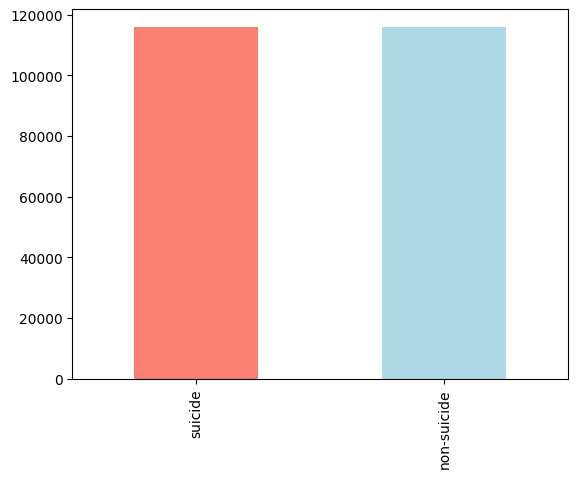

In [7]:
data["class"].value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

In [8]:
data = data.drop("Unnamed: 0", axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    232074 non-null  object
 1   class   232074 non-null  object
dtypes: object(2)
memory usage: 3.5+ MB


In [9]:
data["text"][1]

"Am I weird I don't get affected by compliments if it's coming from someone I know irl but I feel really good when internet strangers do it"

We have to imbalance the data since the number of people who are thinking about suicide is less than of the people who are not.

In [10]:
# Separate the classes
suicide_df = data[data['class'] == 'suicide']
non_suicide_df = data[data['class'] == 'non-suicide']


undersampled_suicide_df = suicide_df.sample(n=int(len(non_suicide_df)//1.4), random_state=42)
data = pd.concat([undersampled_suicide_df, non_suicide_df]).sample(frac=1, random_state=42)

In [11]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=42)

In [12]:
def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for sent in tqdm(text):
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_stopwords(sent)
        #sent=nfx.remove_shortwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text,text_length

In [13]:
np.random.seed(42)
cleaned_train_text,train_text_length=clean_text(train_data.text)
cleaned_test_text,test_text_length=clean_text(test_data.text)

100%|██████████| 39784/39784 [00:05<00:00, 6699.38it/s]


In [14]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

In [15]:
import pickle

with open('/content/drive/MyDrive/Project/tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [16]:
word_freq=pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)

In [17]:
word_freq.iloc[:30]

,word,count
0,im,200978
16,dont,129695
106,like,114563
119,want,89775
109,know,80076
116,feel,73216
286,life,68636
344,ive,62931
161,cant,61118
55,people,57223


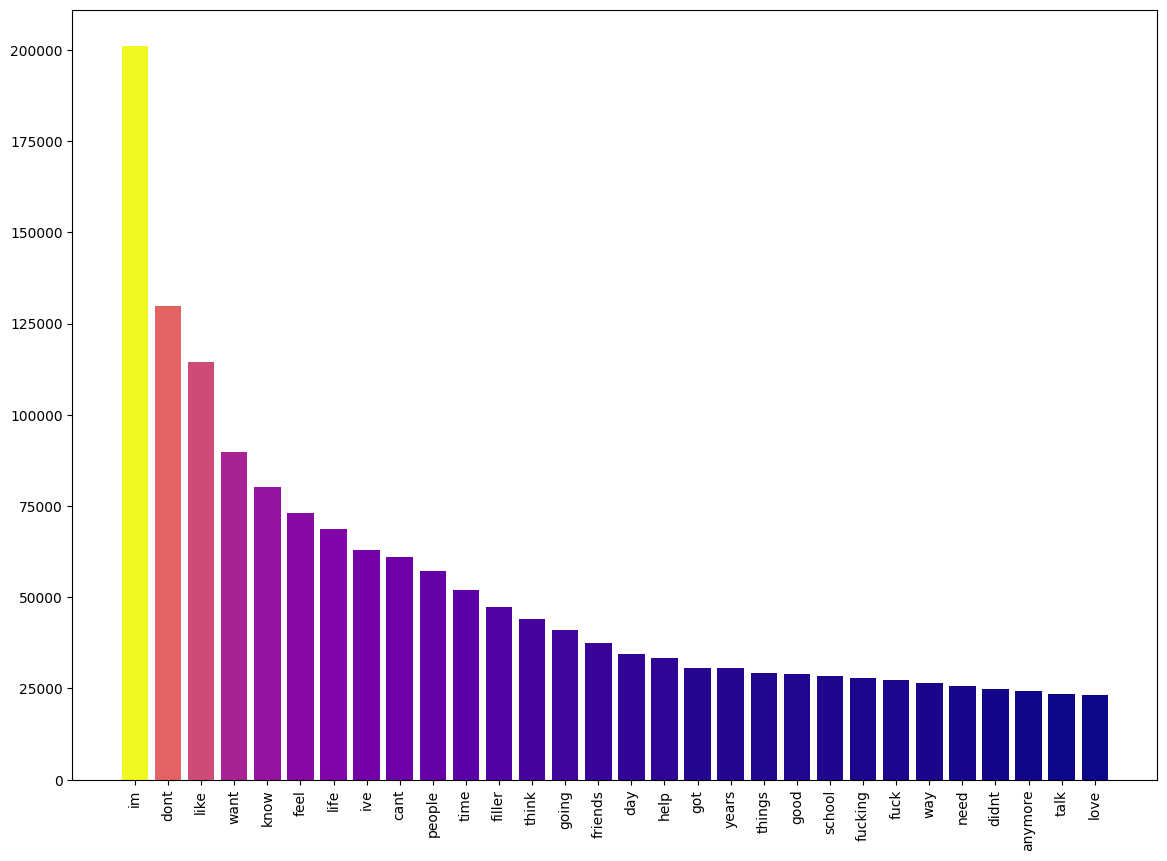

In [18]:
fig, ax = plt.subplots(figsize=(14, 10))
my_cmap = plt.get_cmap("plasma")
y = word_freq["count"].iloc[:30]
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
ax.bar(x=word_freq["word"].iloc[:30], height=word_freq["count"].iloc[:30], color=my_cmap(rescale(y)))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show();

In [19]:
np.random.seed(42)
train_text_seq=tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad=pad_sequences(train_text_seq,maxlen=50)


test_text_seq=tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=50)

In [20]:
np.random.seed(42)
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.transform(test_data['class'])

In [21]:
with open('/content/drive/MyDrive/Project/glove.840B.300d.pkl', 'rb') as fp:
    glove_embedding = pickle.load(fp)

In [22]:
np.random.seed(42)
v=len(tokenizer.word_index)

embedding_matrix=np.zeros((v+1,300), dtype=float)
for word,idx in tokenizer.word_index.items():
    embedding_vector=glove_embedding.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

In [23]:
early_stop=EarlyStopping(patience=5)
reducelr=ReduceLROnPlateau(patience=3)

In [24]:
np.random.seed(42)

class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, head_size, num_heads, ff_dim, dropout=0, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation="relu"),
            # This Dense layer's units will be dynamically set in the call method
            tf.keras.layers.Dense(head_size),  # Placeholder, will adjust dynamically
        ])
        self.dropout1 = tf.keras.layers.Dropout(dropout)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout2 = tf.keras.layers.Dropout(dropout)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, training=False):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.norm1(inputs + attn_output)
        # Dynamically set the output dimension of the last Dense layer to match input dimension
        self.ffn.layers[-1].units = inputs.shape[-1]
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.norm2(out1 + ffn_output)
# Define your model architecture here
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,)),
    tf.keras.layers.Embedding(v+1, 300, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.LSTM(20, return_sequences=True),
    TransformerEncoder(head_size=128, num_heads=4, ff_dim=512, dropout=0.1),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.09),
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [25]:
# np.random.seed(42)
# hybrid_model = model.fit(train_text_pad, train_output,
#               validation_data=(test_text_pad, test_output),
#               epochs=20,
#               batch_size=256,
#               callbacks=[early_stop, reducelr])

Saving our model

In [26]:
# saved_model = model.save('/content/drive/MyDrive/Project/Model/hybrid_model_imbalance.h5')

In [27]:
hybrid_model_load = load_model('/content/drive/MyDrive/Project/Model/hybrid_model_imbalance.h5', custom_objects={'TransformerEncoder': TransformerEncoder})
# with open('/content/drive/MyDrive/Project/tokenizer.pkl', 'rb') as t:
#     tokenizers = pickle.load(t)

In [28]:

text = "I want to kill myself"


def clean_text_single(text):
    text = text.lower()
    text = nfx.remove_special_characters(text)
    text = nfx.remove_stopwords(text)
    return text

# Clean your single text input
cleaned_text = clean_text_single(text)

# Tokenize and pad
sequence = tokenizer.texts_to_sequences([cleaned_text])  # Note the list wrapping
padded_sequence = pad_sequences(sequence, maxlen=50)


# Predict
start_time = time.time()
prediction = hybrid_model_load.predict(padded_sequence)
end_time = time.time()

# Interpret the prediction
threshold = 0.5
classified_output = "suicide" if prediction[0][0] > threshold else "non-suicide"
print(f"Classification result: {classified_output}")
print(f"Time taken for prediction: {end_time - start_time} seconds")

1/1 [==============================] - 2s 2s/step
Classification result: suicide
Time taken for prediction: 1.8447718620300293 seconds


In [29]:
predictions_test = (hybrid_model_load.predict(test_text_pad) > 0.4).astype(int)
predictions_train = (hybrid_model_load.predict(train_text_pad) > 0.4).astype(int)

print('TESTING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(test_output,predictions_test,
                            target_names=lbl_target.inverse_transform([0,1])))

print('TRAINING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(train_output,predictions_train,
                           target_names=lbl_target.inverse_transform([0,1])))

4973/4973 [==============================] - 25s 5ms/step
TESTING DATA CLASSIFICATION REPORT 
 

              precision    recall  f1-score   support

 non-suicide       0.94      0.94      0.94     23248
     suicide       0.92      0.92      0.92     16536

    accuracy                           0.93     39784
   macro avg       0.93      0.93      0.93     39784
weighted avg       0.93      0.93      0.93     39784

TRAINING DATA CLASSIFICATION REPORT 
 

              precision    recall  f1-score   support

 non-suicide       0.97      0.95      0.96     92789
     suicide       0.93      0.96      0.94     66347

    accuracy                           0.95    159136
   macro avg       0.95      0.95      0.95    159136
weighted avg       0.95      0.95      0.95    159136



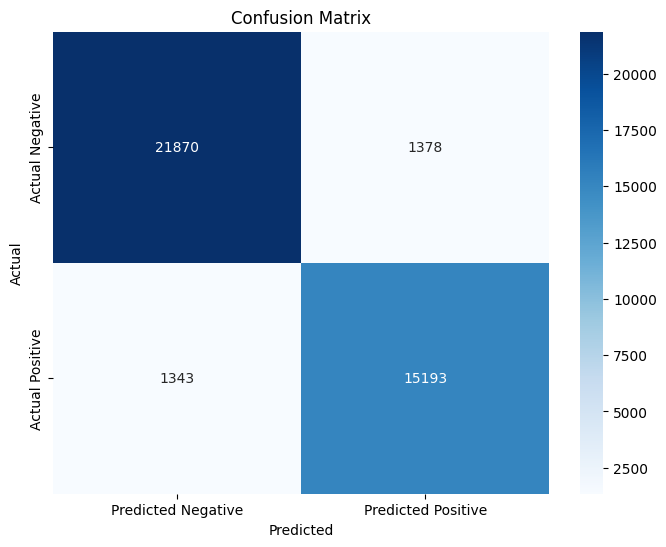

In [30]:
conf = confusion_matrix(test_output, predictions_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Negative", "Predicted Positive"], yticklabels=["Actual Negative", "Actual Positive"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

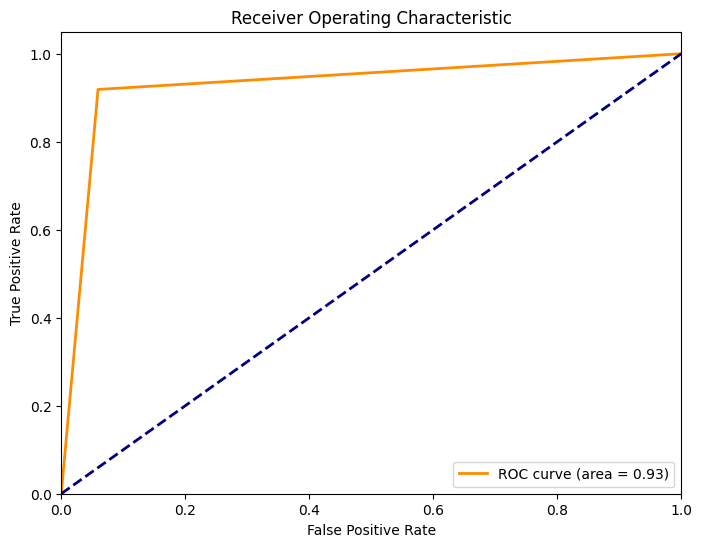

In [31]:

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_output, predictions_test)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [32]:
beta = 0
fbeta = fbeta_score(test_output, predictions_test, beta=beta, average='binary')

print(f"F-beta score with beta={beta}: {fbeta}")

F-beta score with beta=0: 0.9168426769657836


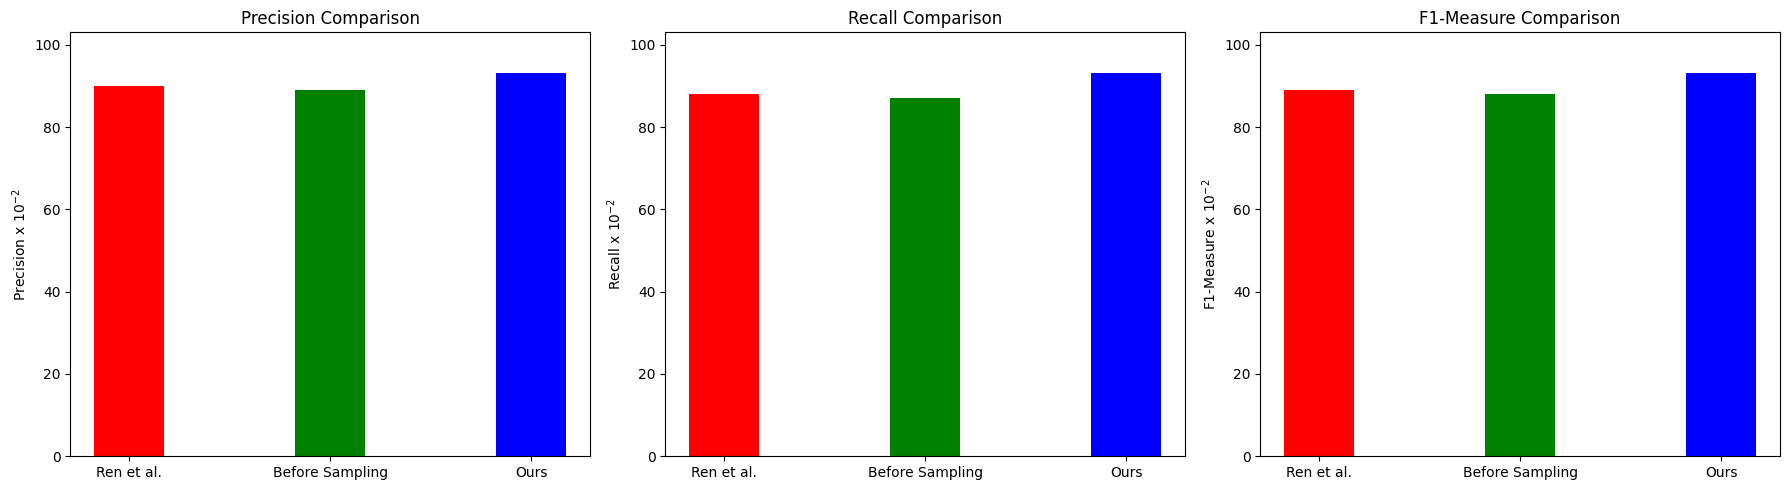

In [33]:
# Import matplotlib and numpy for plotting
import matplotlib.pyplot as plt
import numpy as np

# Given precision, recall, f1-score for 'Ren et al.', 'Before Sampling' and 'Ours'
# These values are placeholders; replace them with your actual values.
ren_precision = 0.90
before_sampling_precision = 0.89  # Placeholder value
our_precision = 0.93

ren_recall = 0.88
before_sampling_recall = 0.87  # Placeholder value
our_recall = 0.93

ren_f1 = 0.89
before_sampling_f1 = 0.88  # Placeholder value
our_f1 = 0.93

# Normalize by multiplying by 10^2 for visualization purposes
ren_precision *= 100
our_precision *= 100
before_sampling_precision *= 100
ren_recall *= 100
our_recall *= 100
before_sampling_recall *= 100
ren_f1 *= 100
our_f1 *= 100
before_sampling_f1 *= 100

# Data for plotting
labels = ['Ren et al.', 'Before Sampling', 'Ours']
precision_scores = [ren_precision, before_sampling_precision, our_precision]
recall_scores = [ren_recall, before_sampling_recall, our_recall]
f1_scores = [ren_f1, before_sampling_f1, our_f1]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns for Precision, Recall, F1-Measure

# Plotting Precision
ax[0].bar(x, precision_scores, width, label='Precision', color=['red', 'green', 'blue'])
ax[0].set_title('Precision Comparison')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].set_ylim(0, max(precision_scores) + 10)  # Adding some space above the highest bar
ax[0].set_ylabel('Precision x $10^{-2}$')

# Plotting Recall
ax[1].bar(x, recall_scores, width, label='Recall', color=['red', 'green', 'blue'])
ax[1].set_title('Recall Comparison')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].set_ylim(0, max(recall_scores) + 10)
ax[1].set_ylabel('Recall x $10^{-2}$')

# Plotting F1-Measure
ax[2].bar(x, f1_scores, width, label='F1-Measure', color=['red', 'green', 'blue'])
ax[2].set_title('F1-Measure Comparison')
ax[2].set_xticks(x)
ax[2].set_xticklabels(labels)
ax[2].set_ylim(0, max(f1_scores) + 10)
ax[2].set_ylabel('F1-Measure x $10^{-2}$')

# Showing the plots
plt.tight_layout()
plt.show()

